In [24]:
from importlib import reload
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.under_sampling import CondensedNearestNeighbour
import xgboost as xgb
import joblib
import pickle
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sma
import statsmodels.stats.outliers_influence  as smo
from scipy.stats import uniform, randint,probplot,shapiro
import model_mngr as modmgr
import split_merge as sm
import add_indicators as indic
import balance
import pandas as pd
import numpy as np
import random as rd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
import maria_import_export as maria
reload(maria)
reload(indic)
reload(sm)
reload(modmgr)
reload(balance)


<module 'balance' from 'C:\\Projets\\MarketDataEnrichment\\dataset_mngr\\balance.py'>

Load data for CW8 ETF from Maria
Add indicators and labels and save the dataset on disk

In [25]:
PATH_DATA = "../../../Data/DTS_FULL/"
PATH_MODEL = "../../../Data/Models/"
symb = "CW8"
dts_name = "DCA_CLOSE_1D_V1"
rnd_key = int(maria.get_conf("RANDOM_KEY"))
df = pd.DataFrame()
if "con" in locals():
    maria.close_connection(con)
con = maria.get_connection()
df = maria.get_candles_to_df(con=con, symbol=symb, only_close=True)
df = indic.add_indicators_to_df(con=con, df_in=df, dts_name=dts_name)
df.sort_index(inplace=True)
#df.round(5).to_csv(PATH_DATA+dts_name+"_full.zip", sep=",")


Exception during reset or similar
Traceback (most recent call last):
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\pymysql\connections.py", line 756, in _write_bytes
    self._sock.sendall(data)
ConnectionAbortedError: [WinError 10053] Une connexion établie a été abandonnée par un logiciel de votre ordinateur hôte

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\pool\base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\pool\base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\engine\default.py", line 683, in do_rollback
    dbapi_connection.rollback()
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\pymysql\connections.py", line 479, in rollback
    self._exec

Clean the dataset droping useless features
Split the dataset by labels, train, val, conf part

In [26]:
df = indic.drop_indicators_by_type(
    con=con, df_in=df, dts_name=dts_name, symbol=symb, ind_type=0)
list_label = indic.get_ind_list_by_type_for_dts(
    con=con, dts_name=dts_name, symbol=symb, ind_type=2)
dict_split = sm.split_df_by_label_strat(
    df_in=df, list_label=list_label['LABEL'].tolist(), split_timeframe="Q")
print(list_label)
lab = list_label['LABEL'][3]
df_test = dict_split['df_'+lab+'_train']
df_test.sort_index(inplace=True)
print(df_test.loc[:, lab].dropna().iloc[[0, -1]])


           LABEL
0   lab_perf_21d
1   lab_perf_62d
2  lab_perf_125d
3  lab_perf_250d
OPEN_DATETIME
2010-03-25    0.030486
2019-12-31    0.043932
Name: lab_perf_250d, dtype: float64


selection of the df studied and plot data to check
!! change lab_studied and algo_studied before training !!

In [27]:
# dict_split.keys()
lab_studied = "lab_perf_62d"
algo_studied = "RANDOM_FOREST_REG"
df_studied = "df_"+lab_studied
df_selected = dict_split[df_studied+'_train']
df_valid = dict_split[df_studied+'_valid']
df_confirm = dict_split[df_studied+'_confirm']


get list of features, depends where we are in the process

In [28]:
#begining, no model not ds_fitlered, we use all finales features
# list_feat = indic.get_ind_list_by_type_for_dts(
#     con=con, dts_name=dts_name, symbol=symb, ind_type=1)
# list_feat = list_feat['LABEL'].tolist()

# features filtered, we use features from the dataframe
#filter features for the studied label
df_selected = indic.drop_indicators_not_selected(con=con, df_in=df_selected, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_valid = indic.drop_indicators_not_selected(con=con, df_in=df_valid, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_confirm = indic.drop_indicators_not_selected(con=con, df_in=df_confirm, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_selected.head()
list_feat = df_selected.columns.values.tolist()
list_feat.remove(lab_studied)
list_feat

['pos_sma200',
 'pos_sma50_200',
 'pos_sma20_50',
 'rsi14',
 'sma20_rsi14',
 'ret_1d',
 'ret_5d',
 'pos_top20',
 'pos_top50',
 'pos_bot20',
 'pos_bot50',
 'aroon14_up',
 'pos_top_200',
 'pos_bot_200',
 'pos_stdev20_sma5']

Check data for each  label

In [ ]:
(df.loc[:, list_label["LABEL"]]).hist(figsize=(8, 10))

Check if label is a normal distribution with a qq plot and shapiro

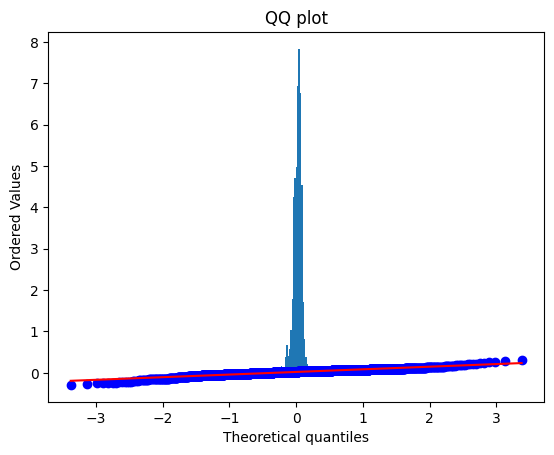

nb lines in data : 1919
NOT a normal distribution p=2.1530570012814328e-23


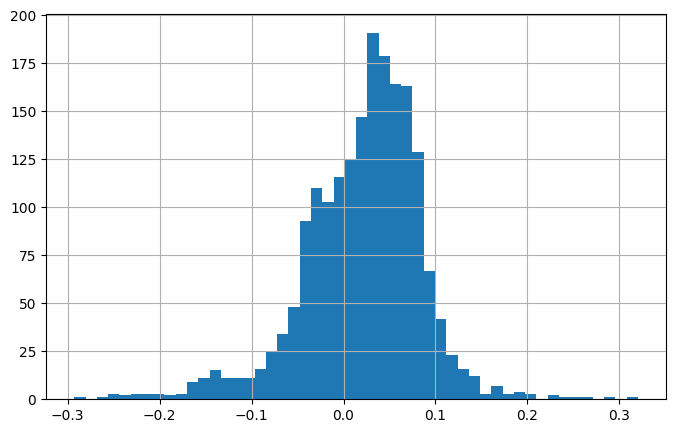

In [29]:
data = df_selected[lab_studied]
#data = df[lab_studied]
plt.hist(data, bins=30, density=True)
probplot(data, plot=plt)
plt.title('QQ plot')
plt.show()
data.hist(figsize=(8, 5),bins=50,)

stat, p = shapiro(data)
#p=round(p,10)
print(f"nb lines in data : {data.shape[0]}")
if p > 0.05:
    print(f"OK normal distribution p={p}" )
else:
    print(f"NOT a normal distribution p={p}")

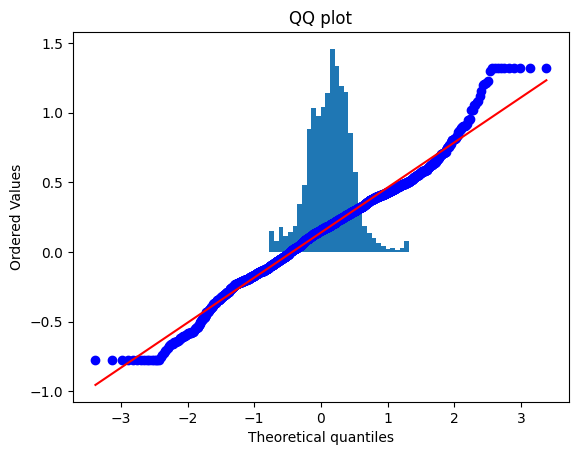

nb lines in data : 1919
NOT a normal distribution p=2.828897326893204e-13


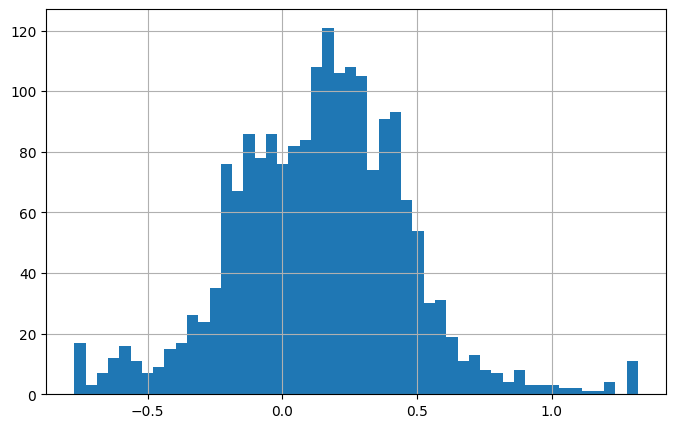

In [30]:
df_clipped=balance.clipping_col(df_in=df_selected,str_col=lab_studied,min_val=-0.2,max_val=0.2)
df_clipped[lab_studied]=df_clipped[lab_studied]*5
#df_rus=balance.reg_undersampler_by_class(df_in=df_clipped,str_label=lab_studied,str_method="NearMiss", nb_class=50,strat="auto")
# df_rus.describe()
#df_log,shift_log=balance.log_transform_label(df_in=df_clipped,str_label=lab_studied)
#data =  df_log[lab_studied]
df_yeo,pt=balance.yeo_johnson_transform_col(df_in=df_clipped,str_col=lab_studied)
balance.save_transformer(transformer=pt,filename=PATH_MODEL+symb+"_PT_"+lab_studied+".pkl")
data=df_yeo[lab_studied]
plt.hist(data, bins=30, density=True)
probplot(data, plot=plt)
plt.title('QQ plot')
plt.show()
data.hist(figsize=(8, 5),bins=50,)

stat, p = shapiro(data)
#p=round(p,10)
print(f"nb lines in data : {data.shape[0]}")
if p > 0.05:
    print(f"OK normal distribution p={p}" )
else:
    print(f"NOT a normal distribution p={p}")

split dataframe into X,y

In [31]:
df_selected=df_yeo  # if df_select has been under sampled before
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_selected, list_features=list_feat, str_label=lab_studied, drop_na=True)
df_x_valid, col_y_valid = sm.split_df_x_y(
    df_in=df_valid, list_features=list_feat, str_label=lab_studied, drop_na=True)
print(f"nb rows train : {df_x_train.shape[0]} nb rows valid : {df_x_valid.shape[0]}")



nb rows train : 1919 nb rows valid : 703


Analysis of train set, heatmap correlation 

<AxesSubplot: >

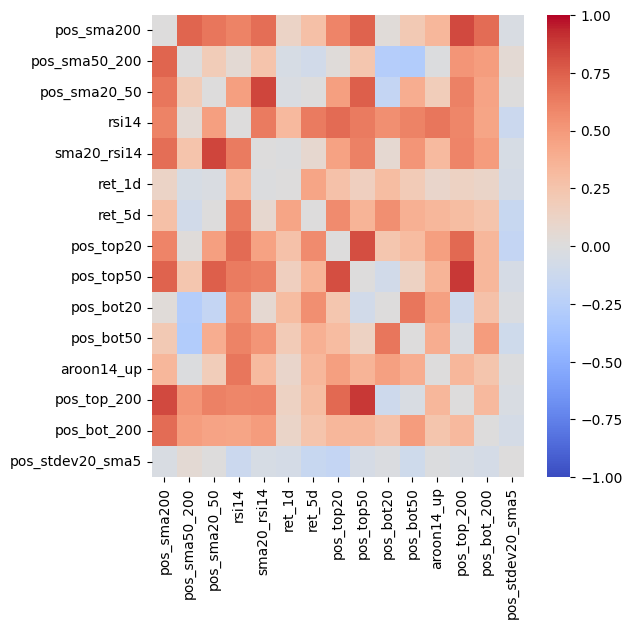

In [32]:
corr_train = df_x_train.corr()
fig, ax = plt.subplots(figsize=(6, 6))
corr_train.replace(1,0,inplace=True)
#corr_train=corr_train.applymap(lambda x : None if x< 0.9 and x>-0.9 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)
sns.heatmap(corr_train, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)


Variance Inflation Factor

In [ ]:
df_x_train_VIF = sma.add_constant(df_x_train)
vif = pd.DataFrame()
vif["feature"]=df_x_train_VIF.columns
vif["VIF"]= [smo.variance_inflation_factor(df_x_train_VIF.values, i) for i in range(df_x_train_VIF.shape[1])]
print(vif)


Feature analysis with Boruta

In [ ]:
rf_bo = RandomForestRegressor(n_estimators=100, n_jobs=-1)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key))
boruta_selector.fit(df_x_train.values, col_y_train.values)
selected_features = df_x_train.columns[boruta_selector.support_]
print(selected_features)


Hyperparameter tuning for Random Forest with  search CV

In [33]:
# number of trees in the foreset
n_estimators = np.linspace(50, 100, 3, endpoint=True,dtype=int)
# max number of features considered for splitting a node
max_features = ['sqrt']
# max number of levels in each decision tree
max_depth = np.linspace(2, 6, 5, endpoint=True,dtype=int)
# min number of data points placed in a node before the node is split
min_samples_split = np.linspace(0.1, 0.5, 5, endpoint=True)
# min number of data points allowed in a leaf node
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()

rf_fitted = modmgr.search_cv_fit_report(estimator=rf, params=grid,
                                           x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=100, n_top=5,method="grid")



Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Accuracy train (neg_mean_squared_error) :-0.09154870871505245
Model with rank: 1
Mean validation score: -0.09651648282916125 (std: 0.0539950258302342)
Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.4, 'n_estimators': 50}

Model with rank: 2
Mean validation score: -0.09689977920041626 (std: 0.0526848105298311)
Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.1, 'n_estimators': 100}

Model with rank: 3
Mean validation score: -0.09690961632556465 (std: 0.053096420366377454)
Parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'n_estimators': 50}

Model with rank: 4
Mean validation score: -0.0969830198831726 (std: 0.052176441905144734)
Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'n_estimators': 50}

Model with ran

check parameters and test with validation dataset and show feature importance

In [34]:
rand_frst_reg = RandomForestRegressor(n_estimators=50,  criterion="squared_error",
                                      random_state=rnd_key, max_depth=3, min_samples_split=0.4, min_samples_leaf=0.2, max_features="sqrt")
rand_frst_reg.fit(df_x_train, col_y_train)

print(f"Training score : {rand_frst_reg.score(df_x_train, col_y_train)}")

y_pred_valid = rand_frst_reg.predict(df_x_valid)
print(
    f"Random Forest regressor valid score:{rand_frst_reg.score(df_x_valid,col_y_valid)}")

feat_imp = rand_frst_reg.feature_importances_
std_feat_imp = np.std(
    [tree.feature_importances_ for tree in rand_frst_reg.estimators_], axis=0)
pd.Series(feat_imp, index=df_x_train.columns).sort_values(ascending=False)


Training score : 0.14651187155380152
Random Forest regressor valid score:-3.6644089855557427


pos_sma50_200       0.231323
pos_sma200          0.152403
sma20_rsi14         0.132650
pos_bot_200         0.126493
pos_top_200         0.101699
pos_top50           0.070834
pos_top20           0.066959
rsi14               0.044311
pos_sma20_50        0.032833
pos_bot50           0.020494
aroon14_up          0.020000
ret_1d              0.000000
ret_5d              0.000000
pos_bot20           0.000000
pos_stdev20_sma5    0.000000
dtype: float64

save model

In [35]:
ext_pkl = ".pkl"
rf_suffix = "_rf_reg_v2"
joblib.dump(rand_frst_reg, PATH_MODEL+symb+"_"+lab_studied+rf_suffix+ext_pkl)

['../../../Data/Models/CW8_lab_perf_62d_rf_reg_v2.pkl']

In [ ]:
rf_check=joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_rf_reg_v1"+ext_pkl)
print(rf_check.get_params())
print(
    f"Random Forest regressor score:{rf_check.score(df_x_valid,col_y_valid)}")
feat_imp = rf_check.feature_importances_
pd.Series(feat_imp, index=df_x_train.columns).sort_values(ascending=False)

Same thing with XGBoost
Hyperparameter tuning for XGBoost with search CV

In [36]:
grid = {
    # default 1 subsample ratio of columns when constructing each tree
    "colsample_bytree": [x for x in np.linspace(0.7, 1.0, num=4, endpoint=True)],
    # default 0 minimum loss reduction to make a further patition on a leaf
    "gamma": [x for x in np.linspace(0, 0.1, num=3, endpoint=True)],
    "learning_rate": [x for x in np.linspace(0.1, 0.1, num=1, endpoint=True)],  # default 0.1
    # default 6 max depth of the tree
    "max_depth": [int(x) for x in np.linspace(1, 2, num=2, endpoint=True,dtype=int)],
    # default 100
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=100, num=3, endpoint=True,dtype=int)],
    # default 1 subsample ratio of the training instances
    "subsample": [x for x in np.linspace(0.6, 1.0, num=3, endpoint=True)],
    # default 1 minimum sum of instance weight needed in a child
    "min_child_weight": [x for x in np.linspace(1.5, 2, num=3, endpoint=True)]
}

xgb_reg = xgb.XGBRegressor()

xgb_fitted = modmgr.search_cv_fit_report(estimator=xgb_reg, params=grid,
                                           x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=1000, n_top=10,method='grid')



Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Accuracy train (neg_mean_squared_error) :-0.0702998660174431
Model with rank: 1
Mean validation score: -0.09130140914541904 (std: 0.039813713288939574)
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1.5, 'n_estimators': 50, 'subsample': 0.8}

Model with rank: 1
Mean validation score: -0.09130140914541904 (std: 0.039813713288939574)
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1.75, 'n_estimators': 50, 'subsample': 0.8}

Model with rank: 1
Mean validation score: -0.09130140914541904 (std: 0.039813713288939574)
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 2.0, 'n_estimators': 50, 'subsample': 0.8}

Model with rank: 1
Mean validation score: -0.09130140914541904 (std: 0.039813713288939574)
Parameters: {'colsample_bytree': 1.0, 'gamma': 0

In [ ]:
# modmgr.report_best_scores(xgb_fitted.cv_results_, 10)

Training score : 0.3375060111184539
Accuracy XGBoost regressor Validation score :-7.715180730954357


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

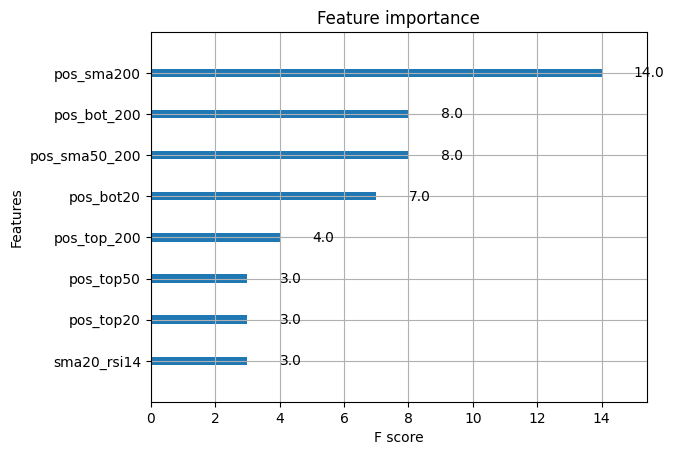

In [39]:
params = {
    "learning_rate": 0.1,
    "subsample": 0.8,
    "gamma": 0,
    "colsample_bytree": 1.0,
    "max_depth": 1,
    "n_estimators": 50,
    "min_child_weight": 1.5
}

xgb_reg = xgb.XGBRegressor(random_state=int(rnd_key),
                           learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],
                           colsample_bytree=params['colsample_bytree'], max_depth=params['max_depth'],
                           n_estimators=params['n_estimators'], min_child_weight=params['min_child_weight'], verbosity=1)

# xgb_reg=xgb.XGBRegressor()
xgb_reg.fit(df_x_train, col_y_train)

print(f"Training score : {xgb_reg.score(df_x_train, col_y_train)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(
    f"Accuracy XGBoost regressor Validation score :{xgb_reg.score(df_x_valid,col_y_valid)}")

# print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_reg)


In [40]:
ext_pkl = ".pkl"
xgb_suffix = "_xgb_reg_v2"
joblib.dump(xgb_reg, PATH_MODEL+symb+"_"+lab_studied+xgb_suffix+ext_pkl)


['../../../Data/Models/CW8_lab_perf_62d_xgb_reg_v2.pkl']

Same thing with Ridge regression 
Hyperparameter tuning for Logistic Regression with random search CV

In [41]:
grid = {
    "solver": ["svd", "cholesky", "lsqr", "sag"],
    "alpha": [x for x in np.logspace(1e-5, 100, 20)],
    "fit_intercept": [True, False],
    "normalize": [True, False]
}
lin_reg = Ridge()

lin_fitted = modmgr.search_cv_fit_report(estimator=lin_reg, params=grid,
                                            x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=100, n_top=5)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previo

Accuracy train (neg_mean_squared_error) :-0.08073171712910551
Model with rank: 1
Mean validation score: -0.09409310699187697 (std: 0.044792044593242035)
Parameters: {'alpha': 1.0000230261160268, 'fit_intercept': True, 'normalize': True, 'solver': 'cholesky'}

Model with rank: 2
Mean validation score: -0.09409310699187698 (std: 0.04479204459324206)
Parameters: {'alpha': 1.0000230261160268, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}

Model with rank: 3
Mean validation score: -0.09410324032867591 (std: 0.044802738449227705)
Parameters: {'alpha': 1.0000230261160268, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}

Model with rank: 4
Mean validation score: -0.09411763379109377 (std: 0.04479415055258772)
Parameters: {'alpha': 1.0000230261160268, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}

Model with rank: 5
Mean validation score: -0.0974205137498529 (std: 0.045654358762014756)
Parameters: {'alpha': 1.0000230261160268, 'fit_intercept': False, 'norma

c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in versi

Training score : 0.23676262158662775
Accuracy Ridge regressor Validation:-7.1226778734408835
[-5.72838149e-01 -8.21925699e-01 -6.15454286e-01 -4.60213819e-04
 -1.31695223e-03 -1.90220556e-01 -3.23092001e-01 -7.86364318e-01
 -4.05640467e-01  7.75391435e-01  2.02801407e-01 -1.78329636e-04
 -1.70884742e-01 -2.60058575e-01  6.56223527e-03]


c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


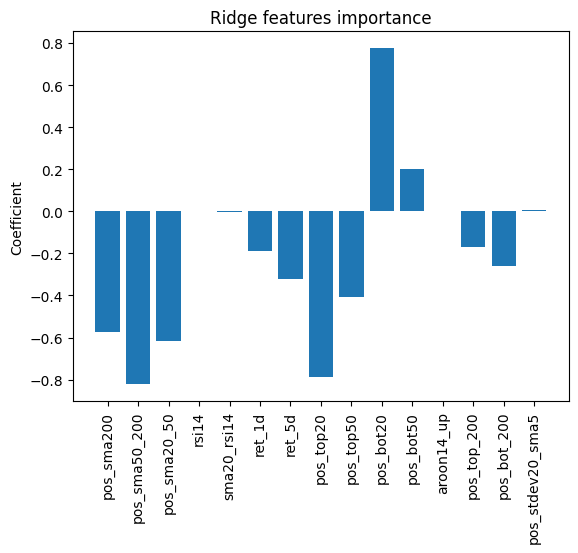

In [42]:


params = {
    "solver": "cholesky",
    "normalize": True,
    "fit_intercept": True,
    "alpha": 1
}

lin_reg = Ridge(random_state=int(rnd_key),
                solver=params['solver'], normalize=params['normalize'], fit_intercept=params['fit_intercept'],
                alpha=params['alpha'])

lin_reg.fit(df_x_train, col_y_train)

print(f"Training score : {lin_reg.score(df_x_train, col_y_train)}")

print(
    f"Accuracy Ridge regressor Validation:{lin_reg.score(df_x_valid,col_y_valid)}")

print(lin_reg.coef_)


plt.bar(df_x_train.columns, lin_reg.coef_)
plt.xticks(range(len(df_x_train.columns)), df_x_train.columns, rotation=90)
plt.ylabel('Coefficient')
plt.title('Ridge features importance')
plt.show()


In [43]:
ext_pkl = ".pkl"
ridge_suffix = "_ridge_reg_v2"
joblib.dump(lin_reg, PATH_MODEL+symb+"_"+lab_studied+ridge_suffix+ext_pkl)

['../../../Data/Models/CW8_lab_perf_62d_ridge_reg_v2.pkl']

Generate scores values  for the dataset and save in csv

In [44]:
rf_check = joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_rf_reg_v2"+ext_pkl)
xgb_check = joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_xgb_reg_v2"+ext_pkl)
ridge_check = joblib.load(
    PATH_MODEL+symb+"_"+lab_studied+"_ridge_reg_v2"+ext_pkl)

# RF XGB and Ridge use the same features actually
algo_studied = "RANDOM_FOREST_REG"
df_prep = indic.drop_indicators_not_selected(
    con=con, df_in=df, dts_name=dts_name, symbol=symb, label=lab_studied, algo=algo_studied)
df_predict = indic.drop_indicators_by_type(
    con=con, df_in=df_prep, dts_name=dts_name, symbol=symb, ind_type=2)
df_predict.dropna(inplace=True)
X_cols_reg = df_predict.columns

df_predict['predict_rf'] = rf_check.predict(df_predict[X_cols_reg])
df_predict['predict_xgb'] = xgb_check.predict(df_predict[X_cols_reg])
df_predict['predict_ridge'] = ridge_check.predict(df_predict[X_cols_reg])
print(type(df_predict))
# if yeo johnson transform !!!!!
pt = balance.load_transformer(
    filename=PATH_MODEL+symb+"_PT_"+lab_studied+".pkl")
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_rf', pt=pt)
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_xgb', pt=pt)
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_ridge', pt=pt)
df_predict['predict_rf']=df_predict['predict_rf']/5.0
df_predict['predict_xgb']=df_predict['predict_xgb']/5.0
df_predict['predict_ridge']=df_predict['predict_ridge']/5.0
# END if yeo johnson transform

df_predict['predict_avg'] = (
    df_predict['predict_rf']+df_predict['predict_xgb']+df_predict['predict_ridge'])/3.0

df_prep = df_prep.join(
    df_predict[['predict_rf', 'predict_xgb', 'predict_ridge', 'predict_avg']], how="left")
df_prep.dropna(inplace=True)
df_prep.round(5).to_csv(
    PATH_DATA+dts_name+"_"+lab_studied+"_predict_V2.zip", sep=",")


<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_prep.describe()

In [ ]:
df_can = maria.get_candles_to_df(con=con, symbol=symb, only_close=False)
df_can.sort_index(inplace=True)
df_can.describe()

In [ ]:
df_bt=sm.join_dataframes_backtest(df_candle=df_can,df_score=df_prep,str_col_score='predict_ridge')
df_bt.describe(include='all')
df_bt.round(5).to_csv(
     "../../../Data/backtest/"+dts_name+"_"+lab_studied+"_predict_BT.zip", sep=",")